
# Baltimore Vital Signs

The repo for this notebook lives [here](https://github.com/mkcor/baltimore_vital_signs). It was forked from [https://github.com/jtelszasz/baltimore_vital_signs](https://github.com/jtelszasz/baltimore_vital_signs).

The <a href='http://bniajfi.org/indicators/all'>Baltimore Neighborhoods Indicators Alliance - Jacob France Institute (BNIA)</a> at the University of Baltimore has made it their mission to provide a clean, concise set of indicators that illustrate the health and wealth of the city. There are 152 socio-economic indicators in the Vital Signs dataset, and some are reported for multiple years which results in 295 total variables for each of the 56 Baltimore neighborhoods captured.  The indicators are dug up from a number of sources, including the U.S. Census Bureau and its American Community Survey, the FBI and Baltimore Police Department, Baltimore departments of city housing, health, and education.

In [1]:
import glob
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as pgo

In [2]:
# Load and combine the datasets.
path = 'raw_data/csv'

allFiles = glob.glob(path + '/*.csv')
df = pd.DataFrame()

for i, filename in enumerate(allFiles):
    df_file = pd.read_csv(filename)
    if i == 0:
        df = df_file
    else:
        df = pd.merge(df, df_file)

In [3]:
df.index = df['CSA2010']
df.drop('CSA2010', inplace=True)
print len(df.columns)
del df['CSA2010']
print len(df.columns)

296
295


In [4]:
cols = df.columns
df[cols] = (
    df[cols]
    # Replace things that aren't numbers and change any empty entries to nan
    # (to allow type conversion)
    .replace({r'[^0-9\.]': '', '': np.nan}, regex=True)
    # Change to float and convert from %s
    .astype(np.float64)
)

In [5]:
# One of the rows is an aggregate Baltimore City.
df.drop('Baltimore City', inplace=True)

# A Few Exploratory Plots

## Percentage of Population White in Each Neighborhood, Sorted

In [6]:
df_white_sorted = df['pwhite10'].sort(inplace=False)

In [7]:
# Create a horizontal bar chart with plotly.
data = pgo.Data([
    pgo.Bar(
            y=df_white_sorted.index,
            x=df_white_sorted,
            orientation='h'
    )
])

In [8]:
layout = pgo.Layout(
    title='% White',
    margin=pgo.Margin(l=300)  # add left margin for y-labels are long
)

In [9]:
fig = pgo.Figure(data=data, layout=layout)

In [10]:
# Address InsecurePlatformWarning from running Python 2.7.6
import urllib3.contrib.pyopenssl
urllib3.contrib.pyopenssl.inject_into_urllib3()

In [11]:
py.iplot(fig, filename='baltimore-barh',
         width=700, height=1000)  # adjust notebook display width and height

## Percentage of Households in Poverty and with Children, Sorted

In [12]:
df_chpov_sorted = df['hhchpov12'].sort(inplace=False)

In [13]:
data1 = pgo.Data([
    pgo.Bar(
            y=df_chpov_sorted.index,
            x=df_chpov_sorted,
            orientation='h'
    )
])

In [14]:
# Specify some layout attributes.
layout1 = pgo.Layout(
    title='% HH w. Children in Poverty',
    margin=pgo.Margin(l=300)  # add left margin for y-labels are long
)

In [15]:
fig1 = pgo.Figure(data=data1, layout=layout1)

In [16]:
py.iplot(fig1, filename='baltimore-hh-pov', width=700, height=1000)

## Percentage Households in Poverty with Children vs Percentage Population White (per Neighborhood)

### Bubbles Sized by Juvenile Population (per Neighborhood)

In [17]:
# Juvenile population (age 10 to 18)
juv_pop = df['tpop10'] * df['age18_10'] / 100

In [18]:
# Display this information in hover box.
hover_text = zip(juv_pop.index, np.around(juv_pop, 2))

In [19]:
# Represent a third dimension (size).
data2 = pgo.Data([
    pgo.Scatter(
            x=df['pwhite10'],
            y=df['hhchpov12'],
            mode='markers',
            marker=pgo.Marker(size=juv_pop,
                              sizemode='area',
                              sizeref=juv_pop.max()/600,
                              opacity=0.4,
                              color='blue'),
            text=hover_text
    )
])

In [20]:
layout2 = pgo.Layout(
    title='Baltimore: Too Many Non-White Kids in Poverty',
    xaxis=pgo.XAxis(title='% Population White (2010)',
                    range=[-5, 100],
                    showgrid=False,
                    zeroline=False),
    yaxis=pgo.YAxis(title='% HH w. Children in Poverty (2012)',
                    range=[-5, 100],
                    showgrid=False,
                    zeroline = False),
    hovermode='closest'
)

In [21]:
fig2 = pgo.Figure(data=data2, layout=layout2)

In [22]:
py.iplot(fig2, filename='baltimore-bubble-chart')

## Percentage of Households in Poverty vs Ethnicity's Percentage of Population

Let's do this chart using matplotlib for a change.

In [23]:
import matplotlib.pyplot as plt

In [24]:
mpl_fig, ax = plt.subplots()

size = 100
alpha = 0.5
fontsize = 16

ax.scatter(df['phisp10'], df['hhpov12'], c='r', alpha=alpha, s=size)
ax.scatter(df['paa10'], df['hhpov12'], c='c', alpha=alpha, s=size)
ax.legend(['Hispanic', 'Black'], fontsize=12)

# Turn off square border around plot.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Turn off ticks.
ax.tick_params(axis="both", which="both", bottom="off", top="off",
               labelbottom="on", left="off", right="off", labelleft="on",
               labelsize=16)

ax.set_ylim(-5, 60)
ax.set_xlim(-5, 100)

ax.set_ylabel('% HH in Poverty', fontsize=fontsize)
ax.set_xlabel('% Population', fontsize=fontsize)

Matplotlib code is very long... But sometimes you have existing matplotlib code, right? The good news is, plotly can eat it! 

In [25]:
py.iplot_mpl(mpl_fig, filename='baltimore-poverty')

/home/marianne/plotly/venvs/baltimore-nb/lib/python2.7/site-packages/plotly/matplotlylib/renderer.py:443: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/home/marianne/plotly/venvs/baltimore-nb/lib/python2.7/site-packages/plotly/matplotlylib/renderer.py:479: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



So, at the moment, matplotlib legends do not fully convert to plotly legends (please refer to our [user guide](https://plot.ly/python/matplotlib-to-plotly-tutorial/#Careful,-matplotlib-is-not-perfect-%28yet%29)). Let's tweak this now.

In [26]:
import plotly.tools as tls

In [27]:
# Convert mpl fig object to plotly fig object, resize to plotly's default.
py_fig = tls.mpl_to_plotly(mpl_fig, resize=True)

In [28]:
# Give each trace a name to appear in legend.
py_fig['data'][0]['name'] = py_fig['layout']['annotations'][0]['text']
py_fig['data'][1]['name'] = py_fig['layout']['annotations'][1]['text']

In [29]:
# Delete misplaced legend annotations. 
py_fig['layout'].pop('annotations', None)

[{'align': 'left',
  'font': {'color': '#000000', 'size': 12.0},
  'opacity': 1,
  'showarrow': False,
  'text': 'Hispanic',
  'x': 0.86542338709677413,
  'xanchor': 'left',
  'xref': 'paper',
  'y': 0.94025933721934374,
  'yanchor': 'bottom',
  'yref': 'paper'},
 {'align': 'left',
  'font': {'color': '#000000', 'size': 12.0},
  'opacity': 1,
  'showarrow': False,
  'text': 'Black',
  'x': 0.86542338709677413,
  'xanchor': 'left',
  'xref': 'paper',
  'y': 0.88657932138744955,
  'yanchor': 'bottom',
  'yref': 'paper'}]

In [30]:
# Add legend, place it at the top right corner of the plot.
py_fig['layout'].update(
    showlegend=True,
    legend=pgo.Legend(
        x=1,
        y=1
    )
)

In [31]:
# Send updated figure object to Plotly, show result in notebook.
py.iplot(py_fig, filename='baltimore-poverty')

Hispanic communities are smaller fractions of neighborhood populations.

# Principal Component Analysis

Read this [post](http://www.thetrainingset.com/articles/A-City-Divided-In-N-Dimensions) at The Training Set for purpose of this analysis.

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [45]:
X = np.array(df)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [46]:
pca = PCA()
pca.fit(X_scaled)

PCA(copy=True, n_components=None, whiten=False)

In [47]:
len(pca.components_)

55

55 dimensions (or components, or axes) were used in the Principal Component Analysis.

In [48]:
print 'Explained Variance Ratio = ', sum(pca.explained_variance_ratio_[: 2])

Explained Variance Ratio =  0.483937328909


We can see that almost half (~48%) of the total variance comes from only two dimensions (i.e., the first two principal components). Let's visualize the relative contribution of all components.

In [49]:
data3 = pgo.Data([
    pgo.Bar(
            y=pca.explained_variance_ratio_,
    )
])

In [50]:
py.iplot(data3, filename="baltimore-principal-dimensions")

Let's plot a cumulative version of this, to see how many dimensions are needed to account for 90% of the total variance.

In [51]:
data4 = pgo.Data([
    pgo.Scatter(
            y=np.cumsum(pca.explained_variance_ratio_),
    )
])

In [52]:
py.iplot(data4, filename='baltimore-pca-cumulative')

So we need about 20 dimensions to explain ~90% of the total variance.

Let's focus on the 2 principal dimensions, so it's easy to plot them in the (x, y) plane.

In [41]:
pca.n_components = 2
X_reduced = pca.fit_transform(X_scaled)
df_X_reduced = pd.DataFrame(X_reduced, index=df.index)

In [42]:
trace = pgo.Scatter(x=df_X_reduced[0],
                    y=df_X_reduced[1],
                    text=df.index,
                    mode='markers',
                    # Size by total population of each neighborhood. 
                    marker=pgo.Marker(size=df['tpop10'],
                                      sizemode='diameter',
                                      sizeref=df['tpop10'].max()/50,
                                      opacity=0.5)
)

data5 = pgo.Data([trace])

In [43]:
layout5 = pgo.Layout(title='Baltimore Vital Signs (PCA)',
                     xaxis=pgo.XAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     yaxis=pgo.YAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     hovermode='closest'
)

In [44]:
fig5 = pgo.Figure(data=data5, layout=layout5)
py.iplot(fig5, filename='baltimore-2dim')

We have reduced a high-dimensional problem to a simple model. We can visualize it in 2 dimensions. Neighborhoods which lie closer to one another are more similar (with respect to these 'vital signs', i.e., socio-economic indicators). Downtown seems very special!

# K-means Clustering

In [40]:
from sklearn.cluster import KMeans

#reduced_data = PCA(n_components=2).fit_transform(data)
def cluster(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_reduced)
    Z = kmeans.predict(X_reduced)
    return kmeans, Z

Since the number of clusters assigned is a manual input, we can get a feel for an appropriate number of clusters by plotting the inertia as a function of number of clusters.

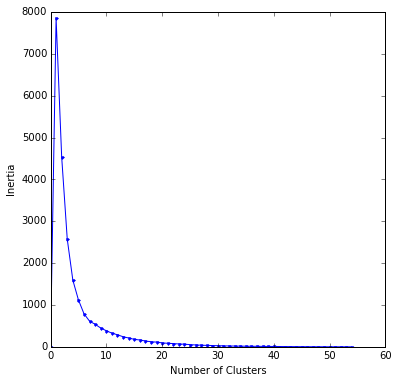

In [42]:
max_clusters = len(df)

inertias = zeros(max_clusters)

for i in range(1,max_clusters):
        kmeans, Z = cluster(i)
        inertias[i] = kmeans.inertia_

fig = plt.figure(figsize=[6,6])
ax1 = plt.subplot(1,1,1)
plot(inertias,marker='.')
xlabel('Number of Clusters')
ylabel('Inertia')
#xlim([1,14])
plt.show()

Below is what the k-means clustering looks like for 7 clusters.

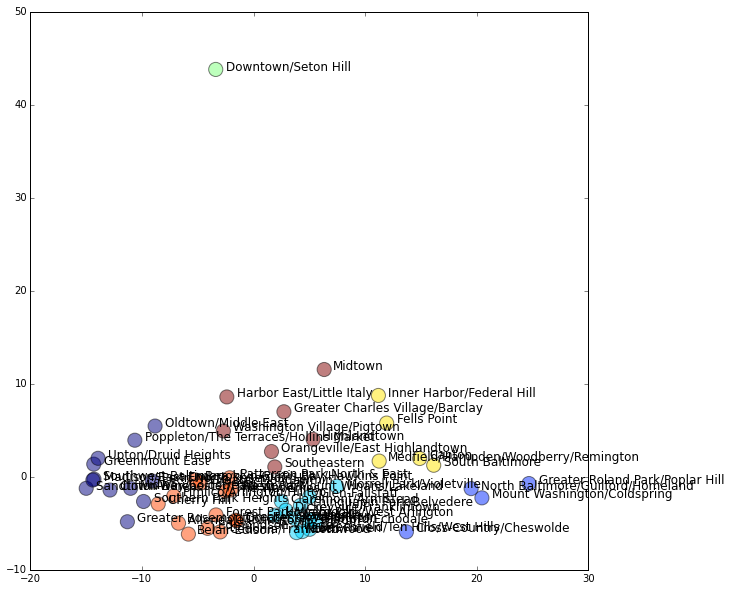

In [11]:
n_clusters = 7
model, Z = cluster(n_clusters)

fig = plt.figure(figsize=[10,10])
ax = plt.subplot(1,1,1)
plt.scatter(df_X_reduced[0], df_X_reduced[1], c=Z, marker='o', alpha=.5, s=200)
#xlim([-7,7])
#ylim([-10,15])
ii=0
for i,j in zip(df_X_reduced[0],df_X_reduced[1]):
    ax.annotate('%s' %df_X_reduced.ix[ii].name, xy=(i,j), xytext=(10,0), textcoords='offset points', fontsize=12, alpha=1.0)
    ii = ii+1
plt.show()

Again, using Plot.ly for interactivity, bubbles sized by total population in neighborhood.

In [26]:
n_clusters = 7
model, Z = cluster(n_clusters)
x_c = model.cluster_centers_[:,0]
y_c = model.cluster_centers_[:,1]

h=1

x = df_X_reduced[0]#.apply(lambda x: x[:-1]).astype(float)
y = df_X_reduced[1]#.apply(lambda x: x[:-1]).astype(float)
xscale = 22
yscale = 10
#schoolage_pop = df['tpop10'] * df['age18_10']/100#.apply(lambda x: x[:-1]).astype(float)

# Plot the decision boundary. For that, we will asign a color to each
x_min, x_max = x.min() + 1, x.max() - 1
y_min, y_max = y.min() + 1, y.max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Zc = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
#Z = Z.reshape(xx.shape)
#plt.figure(1)
#plt.clf()


trace1 = Scatter(x=x,
                 y=y,
                 text = df.index,
                 name = '',
                 mode = 'markers',
                 marker = Marker(size = df['tpop10']/400,
                                 sizemode = 'diameter',
                                 #sizeref = schoolage_pop.max()/1000,
                                 opacity = 0.6,
                                 color = Z)
)

trace2 = Scatter(x=x_c,
                 y=y_c,
                 mode = 'markers',
                 text = '',
                 name='',
                 marker = Marker(symbol='x',
                                 size=15,
                                 color = [0,1,2,3,4,5,6])
)

layout = Layout(
    title = 'Baltimore Vital Signs PCA w/ K-Means Clustering <br> Number of Clusters: 7',
    xaxis = XAxis(range = [-xscale,xscale],
                  title = '',
                  showgrid = False,
                  showline = False,
                  zeroline = False,
                  autotick = False,
                  showticklabels=False),
    yaxis = YAxis(range = [-1*yscale,yscale],
                  title = '',
                  showgrid = False,
                  showline = False,
                  zeroline = False,
                  autotick = False,
                  showticklabels=False),
    autosize = False,
    width=600,
    height=600,
    font = Font(size=14),
    hovermode = 'closest',
    showlegend=False
)

data = Data([trace1,trace2])
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='Baltimore PCA, K-Means Cluster')
